In [1]:
MSASL_TRAIN_PATH = "./MS-ASL/MSASL_train.json"
MSASL_VAL_PATH = "./MS-ASL/MSASL_val.json"
MSASL_TEST_PATH = "./MS-ASL/MSASL_test.json"
MSASL_CLASSES_PATH = "./MS-ASL/MSASL_classes.json"

In [2]:
import json
import pandas as pd

with open(MSASL_TRAIN_PATH) as f:
    train_data = json.load(f)

with open(MSASL_VAL_PATH) as f:
    val_data = json.load(f)

with open(MSASL_TEST_PATH) as f:
    test_data = json.load(f)
    
with open(MSASL_CLASSES_PATH) as f:
    class_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)
class_df = pd.DataFrame(class_data)

class_df.columns = ['label_name']
class_df['label'] = class_df.index

train_df = train_df.merge(class_df, how='left', on='label')
val_df = val_df.merge(class_df, how='left', on='label')
test_df = test_df.merge(class_df, how='left', on='label')

In [3]:
train_df

,org_text,clean_text,start_time,signer_id,signer,start,end,file,label,height,fps,end_time,url,text,box,width,review,label_name
0,match [light-a-MATCH],match,0.000,0,0,0,83,match light-a-MATCH,830,360.0,30.000,2.767,https://www.youtube.com/watch?v=C37R_Ix8-qs,match,"[0.05754461884498596, 0.21637457609176636, 1.0...",640.0,NaN,match
1,FAIL,fail,0.000,0,-1,0,74,FAIL,542,360.0,25.000,2.960,https://www.youtube.com/watch?v=PIsUJl8BN_I,fail,"[0.0657794177532196, 0.16717177629470825, 0.93...",480.0,NaN,fail
2,laugh,laugh,0.000,4,26,0,31,SignSchool Laugh with Legs 2,312,360.0,29.970,1.034,www.youtube.com/watch?v=9FdHlMOnVjg,laugh,"[0.13188594579696655, 0.32334136962890625, 1.0...",640.0,NaN,laugh
3,BOOK,book,0.000,0,-1,0,66,BOOK(3),38,360.0,25.000,2.640,https://www.youtube.com/watch?v=J7tP98oDxqE,book,"[0.05569887161254883, 0.25173279643058777, 0.9...",480.0,NaN,book
4,sign-language,sign language,0.000,0,-1,0,75,SIGN-LANGUAGE-S-CLAW-F,848,360.0,29.970,2.502,www.youtube.com/watch?v=N2mG9ZKjrGA,sign language,"[0.03904399275779724, 0.24198183417320251, 1.0...",640.0,NaN,sign language
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16049,WRITE,write,539.939,32,17,16182,16301,ASL 1 Unit 1 Vocabulary,53,360.0,29.970,543.910,https://www.youtube.com/watch?v=fNg_sJ9f8EI,write,"[0.03217703104019165, 0.3161315321922302, 1.0,...",640.0,NaN,write
16050,hot,hot,0.000,2,42,0,127,Hot,135,360.0,29.657,4.282,https://www.youtube.com/watch?v=MkXUHhsMAns,hot,"[0.00036713480949401855, 0.20649650692939758, ...",640.0,NaN,hot
16051,hi,hi,0.000,0,0,0,47,Hi,379,360.0,29.970,1.568,www.youtube.com/watch?v=rhfJGeMDMzQ,hi,"[0.013705313205718994, 0.17314371466636658, 1....",640.0,NaN,hi
16052,Learn,learn,0.000,135,-1,0,104,ASL Learn,22,360.0,30.000,3.467,https://www.youtube.com/watch?v=n-b2NMAwk28,learn,"[0.18269836902618408, 0.19255371391773224, 1.0...",480.0,NaN,learn


In [5]:
import os
import pandas as pd
import yt_dlp
import glob
import shutil
import random
import cv2

from concurrent.futures import ProcessPoolExecutor, as_completed


OUTPUT_DIR = "./msasl_clips/"
MAX_CLIPS_PER_LABEL = 5 
MIN_CLIP_DURATION = 0.5  
MAX_WORKERS = 4 
TARGET_RESOLUTION = (256, 256) 
MAX_LABELS = 2

if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

open("skipped_videos.txt", "w").close()

def download_and_clip(row_data):
    row, split = row_data
    video_url = row["url"]
    start = float(row["start_time"])
    end = float(row["end_time"])
    label = row["label_name"]
    filename_base = f"{row['file']}_{split}".replace(" ", "_")
    
    label_dir = os.path.join(OUTPUT_DIR, split, label)
    os.makedirs(label_dir, exist_ok=True)
    
    clipped_path = os.path.join(label_dir, f"{filename_base}.mp4")
    
    if os.path.exists(clipped_path):
        return f"Skipped (cached): {clipped_path}"
    
    temp_dir = os.path.join(OUTPUT_DIR, "temp")
    os.makedirs(temp_dir, exist_ok=True)
    temp_video_path = os.path.join(temp_dir, f"{filename_base}_temp.mp4")
    
    ydl_opts = {
        "format": "best[height<=480]", 
        "outtmpl": temp_video_path,
        "quiet": True,
        "no_warnings": True,
        "merge_output_format": "mp4",
    }
    
    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([video_url])
            
    except Exception as e:
        error_msg = str(e).lower()
        
        if any(x in error_msg for x in ["private", "unavailable", "removed", "copyright"]):
            with open("skipped_videos.txt", "a") as logf:
                logf.write(f"{video_url}\n")
            return f"Unavailable video: {video_url}"
            
        return f"Download error: {video_url} - {e}"
    
    try:
        clip_duration = end - start
        
        if clip_duration < MIN_CLIP_DURATION:
            os.remove(temp_video_path)
            return f"Clip too short ({clip_duration}s): {video_url}"
            
        cap = cv2.VideoCapture(temp_video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        start_frame = int(start * fps)
        end_frame = int(end * fps)
        
        if end_frame > total_frames:
            end_frame = total_frames
            print(f"Adjusted end frame to video length: {end_frame}")
        
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(clipped_path, fourcc, fps, TARGET_RESOLUTION)
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        while cap.isOpened() and cap.get(cv2.CAP_PROP_POS_FRAMES) <= end_frame:
            ret, frame = cap.read()
            if not ret:
                break
            
            resized = cv2.resize(frame, TARGET_RESOLUTION)
            out.write(resized)
        
        cap.release()
        out.release()
        
        os.remove(temp_video_path)
        print(f"Saved: {clipped_path}")
        
        return f"Success: {clipped_path}"

    except Exception as e:
        print(f"OpenCV processing failed: {e}")
        
        if os.path.exists(temp_video_path):
            os.remove(temp_video_path)
        return f"Processing error: {video_url} - {e}"

for split_name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    process_split(df, split_name)

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf60.16.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1920, 1080], 'bitrate': 1202, 'fps': 30.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc.', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': 'eng', 'default': True, 'fps': 48000, 'bitrate': 1, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 2.88, 'bitrate': 1193, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [1920, 1080], 'video_bitrate': 1202, 'video_fps': 30.0, 'default

Failed to clip ./msasl_clips/train/fail/FAIL_full.mp4: 'VideoFileClip' object has no attribute 'subclip'


ERROR: [youtube] 9FdHlMOnVjg: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Skipping private/unavailable video: www.youtube.com/watch?v=9FdHlMOnVjg
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf60.16.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [640, 480], 'bitrate': 496, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(Main)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc.', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': 'eng', 'default': True, 'fps': 48000, 'bitrate': 1, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 2.76, 'bitrate': 491, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(Main)', 'video_siz

Failed to clip ./msasl_clips/train/book/BOOK(3)_full.mp4: 'VideoFileClip' object has no attribute 'subclip'
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf60.16.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1920, 1080], 'bitrate': 1271, 'fps': 29.97002997002997, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc.', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': 'eng', 'default': True, 'fps': 48000, 'bitrate': 1, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 2.62, 'bitrate': 1257, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec

ERROR: [youtube] ri3NrdgfAtE: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Skipping private/unavailable video: https://www.youtube.com/watch?v=ri3NrdgfAtE


ERROR: [youtube] l31UXgChCS4: Video unavailable


Skipping private/unavailable video: www.youtube.com/watch?v=l31UXgChCS4


ERROR: [youtube] pt9bV_EvcaU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Skipping private/unavailable video: https://www.youtube.com/watch?v=pt9bV_EvcaU
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf60.16.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [640, 480], 'bitrate': 358, 'fps': 15.0, 'codec_name': 'h264', 'profile': '(Main)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': 'eng', 'default': True, 'fps': 48000, 'bitrate': 1, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 3.88, 'bitrate': 351, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(Main)', 'video_size': [640, 480], 'v

ERROR: [youtube] y8tHmOQcCwU: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Skipping private/unavailable video: https://www.youtube.com/watch?v=y8tHmOQcCwU


ERROR: [youtube] wX78EPtSuzU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Skipping private/unavailable video: www.youtube.com/watch?v=wX78EPtSuzU


ERROR: [youtube] OL02Odh2dRg: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Skipping private/unavailable video: www.youtube.com/watch?v=OL02Odh2dRg


ERROR: [youtube] C59jcSo4fEI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Skipping private/unavailable video: www.youtube.com/watch?v=C59jcSo4fEI


ERROR: [youtube] Qs2ua1S6tg0: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Skipping private/unavailable video: www.youtube.com/watch?v=Qs2ua1S6tg0


ERROR: [youtube] -kgTBeOw95A: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Skipping private/unavailable video: www.youtube.com/watch?v=-kgTBeOw95A


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_clip_counts(base_dir):
    split_dirs = ["train", "val", "test"]
    all_counts = []

    for split in split_dirs:
        split_path = os.path.join(base_dir, split)
        if not os.path.exists(split_path):
            continue
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if os.path.isdir(label_path):
                clip_count = len(glob.glob(os.path.join(label_path, "*.mp4")))
                all_counts.append({"split": split, "label": label, "count": clip_count})
    
    df_counts = pd.DataFrame(all_counts)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_counts, x="label", y="count", hue="split")
    plt.title("Number of clips per label per split")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_clip_counts(OUTPUT_DIR)

def collect_clip_durations(base_dir):
    durations = []
    for root, _, files in os.walk(base_dir):
        for f in files:
            if f.endswith(".mp4"):
                path = os.path.join(root, f)
                cap = cv2.VideoCapture(path)
                fps = cap.get(cv2.CAP_PROP_FPS)
                frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
                duration = frames / fps if fps > 0 else 0
                label = os.path.basename(os.path.dirname(path))
                split = os.path.basename(os.path.dirname(os.path.dirname(path)))
                durations.append({"split": split, "label": label, "duration": duration})
                cap.release()
    return pd.DataFrame(durations)

df_durations = collect_clip_durations(OUTPUT_DIR)

plt.figure(figsize=(10, 6))
sns.histplot(data=df_durations, x="duration", hue="split", bins=20, kde=True)
plt.title("Distribution of Clip Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random
import os
import glob
import cv2
import pandas as pd
import seaborn as sns


def show_sample_frames(base_dir, num_clips=3, frames_per_clip=5):
    mp4_files = glob.glob(os.path.join(base_dir, "**", "*.mp4"), recursive=True)
    samples = random.sample(mp4_files, min(num_clips, len(mp4_files)))

    for clip_path in samples:
        cap = cv2.VideoCapture(clip_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(1, total_frames // frames_per_clip)
        frame_indices = [i * step for i in range(frames_per_clip)]
        
        fig, axes = plt.subplots(1, frames_per_clip, figsize=(15, 3))
        fig.suptitle(f"Clip: {os.path.basename(clip_path)}", fontsize=12)

        for i, frame_idx in enumerate(frame_indices):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                axes[i].imshow(frame_rgb)
                axes[i].axis("off")
            else:
                axes[i].set_visible(False)

        cap.release()
        plt.tight_layout()
        plt.show()

def collect_mp4_stats(base_dir):
    stats = []

    for path in glob.glob(os.path.join(base_dir, "**", "*.mp4"), recursive=True):
        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            continue

        frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = frames / fps if fps > 0 else 0
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        label = os.path.basename(os.path.dirname(path))
        split = os.path.basename(os.path.dirname(os.path.dirname(path)))

        stats.append({
            "file": os.path.basename(path),
            "split": split,
            "label": label,
            "duration": duration,
            "fps": fps,
            "width": width,
            "height": height,
            "resolution": f"{width}x{height}",
        })

        cap.release()

    return pd.DataFrame(stats)

df_stats = collect_mp4_stats(OUTPUT_DIR)
print(df_stats.head())
show_sample_frames(OUTPUT_DIR, num_clips=3, frames_per_clip=5)

plt.figure(figsize=(10, 5))
sns.histplot(df_stats["duration"], bins=30, kde=True)
plt.title("Distribution of Clip Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_stats["fps"], bins=20, kde=True)
plt.title("Distribution of FPS")
plt.xlabel("Frames per Second")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=df_stats, x="resolution", order=df_stats["resolution"].value_counts().index)
plt.title("Video Resolution Distribution")
plt.xticks(rotation=45)
plt.ylabel("Number of Clips")
plt.xlabel("Resolution")
plt.show()

In [ ]:
from IPython.display import Video

Video("./msasl_clips/train/book/BOOK(3)_full.mp4", embed=True, width=640, height=360)

In [3]:
import os
import torch
import torch.nn as nn
import random
import numpy as np

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_video
from decord import VideoReader
from decord import cpu


class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=30):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames
        self.classes = sorted(os.listdir(root_dir))
        self.video_paths = []

        for label in self.classes:
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for file in os.listdir(label_dir):
                    if file.endswith(".mp4"):
                        self.video_paths.append((os.path.join(label_dir, file), label))

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path, label = self.video_paths[idx]

        vr = VideoReader(video_path, ctx=cpu(0))
        total_frames = len(vr)

        indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        frames = vr.get_batch(indices).asnumpy()

        images = [Image.fromarray(frame) for frame in frames]
        if self.transform:
            images = [self.transform(img) for img in images]
        
        frames_tensor = torch.stack(images)

        label_idx = self.classes.index(label)
        return frames_tensor, label_idx


In [4]:
video_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.RandomHorizontalFlip(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [5]:
train_dir = "./msasl_clips/train/"

train_dataset = VideoDataset(root_dir=train_dir, transform=video_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=False,
    persistent_workers=True
)

for frames, labels in train_loader:
    print(f"Frames shape: {frames.shape}")
    print(f"Labels: {labels}")
    break

Frames shape: torch.Size([16, 30, 3, 128, 128])
Labels: tensor([29, 27,  4,  3,  9, 17, 23, 25, 24,  7, 11, 21,  5,  2,  6, 30])


In [6]:
val_dir = "./msasl_clips/val/"

val_dataset = VideoDataset(root_dir=val_dir, transform=video_transforms)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,  
    shuffle=True,
    num_workers=2,
    persistent_workers=True
)

for frames, labels in val_loader:
    print(f"frames shape: {frames.shape}")
    print(f"labels: {labels}")
    break

frames shape: torch.Size([9, 30, 3, 128, 128])
labels: tensor([5, 2, 6, 1, 7, 4, 0, 3, 6])


In [11]:
test_dir = "./msasl_clips/test/"

test_dataset = VideoDataset(root_dir=test_dir, transform=video_transforms)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,  
    shuffle=True,
    num_workers=3,  
    persistent_workers=True
)

for frames, labels in test_loader:
    print(f"frames shape: {frames.shape}")
    print(f"labels: {labels}")
    break

frames shape: torch.Size([16, 30, 3, 128, 128])
labels: tensor([ 4, 10, 21, 18,  2,  5, 23, 16,  7, 20, 22, 24,  1, 12,  8, 19])


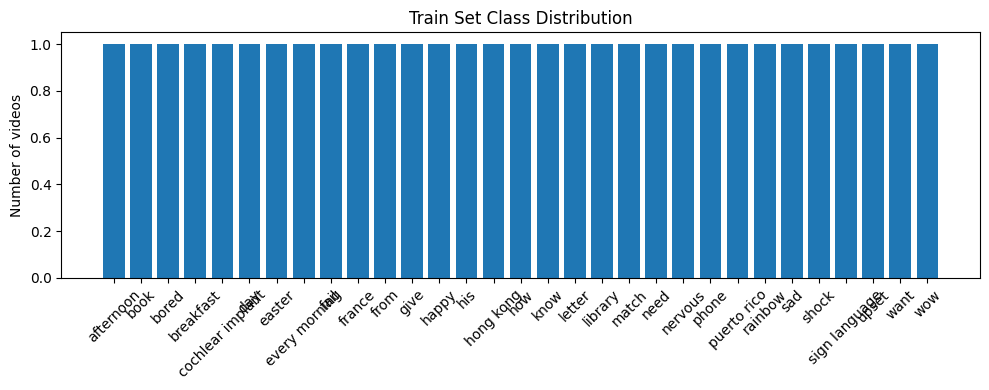

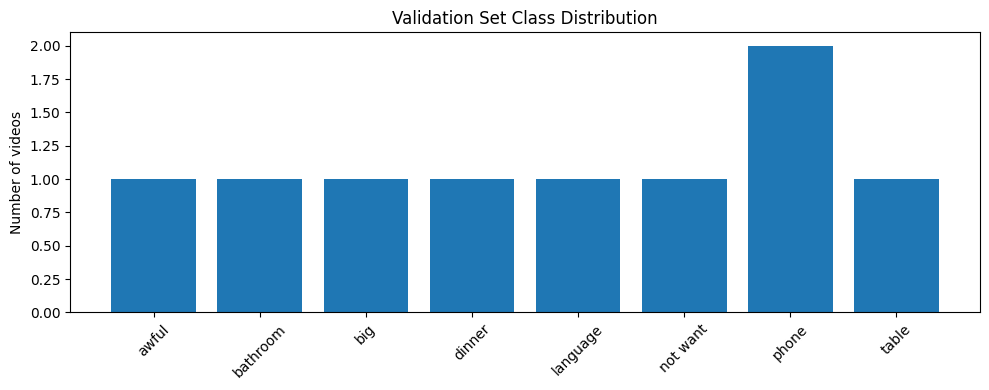

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(dataset, title="Class Distribution"):
    labels = [label for _, label in dataset.video_paths]
    label_names = dataset.classes
    label_counts = Counter(labels)
    counts = [label_counts[label] for label in label_names]

    plt.figure(figsize=(10, 4))
    plt.bar(label_names, counts)
    plt.xticks(rotation=45)
    plt.ylabel("Number of videos")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_dataset, title="Train Set Class Distribution")
plot_class_distribution(val_dataset, title="Validation Set Class Distribution")

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(dataset, title="Class Distribution"):
    labels = [label for _, label in dataset.video_paths]
    label_names = dataset.classes
    label_counts = Counter(labels)
    counts = [label_counts[label] for label in label_names]

    plt.figure(figsize=(10, 4))
    plt.bar(label_names, counts)
    plt.xticks(rotation=45)
    plt.ylabel("Number of videos")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_dataset, title="Train Set Class Distribution")
plot_class_distribution(val_dataset, title="Validation Set Class Distribution")

def get_frame_counts(dataset):
    frame_counts = []
    for video_path, _ in dataset.video_paths:
        frames, _, _ = read_video(video_path, pts_unit="sec")
        frame_counts.append(len(frames))
    return frame_counts

train_frame_counts = get_frame_counts(train_dataset)

plt.figure(figsize=(8, 4))
plt.hist(train_frame_counts, bins=20)
plt.title("Distribution of Video Frame Counts")
plt.xlabel("Frame Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetForVideoClassification(nn.Module):
    def __init__(self, num_classes, num_frames=30):
        super().__init__()
        self.num_frames = num_frames
        
        base_model = models.resnet18(pretrained=True)
        base_model.fc = nn.Identity()  
        
        self.resnet = base_model
        self.fc = nn.Linear(base_model.fc.in_features if hasattr(base_model.fc, 'in_features') else 512, num_classes)

    def forward(self, x):
        batch_size, frames, c, h, w = x.shape 
        
        x = x.view(-1, c, h, w)  
        
        features = self.resnet(x)  
        features = features.view(batch_size, frames, -1) 
        features = features.mean(dim=1)  
        
        return self.fc(features)  

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)
num_frames = 30  

model = ResNetForVideoClassification(num_classes=num_classes, num_frames=num_frames).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for frames, labels in train_loader:
        frames = frames.to(device)  
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = frames.to(device)
            labels = labels.to(device)
            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

/home/segus-faultise/Projects/CAB420_GROUP_A/cab420_GROUP_A_ENV/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/segus-faultise/Projects/CAB420_GROUP_A/cab420_GROUP_A_ENV/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Train Loss: 3.7509, Train Acc: 6.45% | Val Loss: 4.5165, Val Acc: 0.00%
Epoch [2/10] Train Loss: 2.5782, Train Acc: 32.26% | Val Loss: 4.4859, Val Acc: 0.00%
Epoch [3/10] Train Loss: 2.0128, Train Acc: 58.06% | Val Loss: 4.4207, Val Acc: 0.00%
Epoch [4/10] Train Loss: 1.5261, Train Acc: 67.74% | Val Loss: 4.3348, Val Acc: 0.00%
Epoch [5/10] Train Loss: 1.3371, Train Acc: 67.74% | Val Loss: 4.2779, Val Acc: 0.00%
Epoch [6/10] Train Loss: 1.1753, Train Acc: 70.97% | Val Loss: 4.2749, Val Acc: 0.00%
Epoch [7/10] Train Loss: 1.1116, Train Acc: 64.52% | Val Loss: 4.2556, Val Acc: 0.00%
Epoch [8/10] Train Loss: 1.0389, Train Acc: 67.74% | Val Loss: 4.2716, Val Acc: 0.00%
Epoch [9/10] Train Loss: 1.0028, Train Acc: 67.74% | Val Loss: 4.3029, Val Acc: 0.00%
Epoch [10/10] Train Loss: 1.0004, Train Acc: 64.52% | Val Loss: 4.3447, Val Acc: 0.00%
